In [1]:
# from bc_algos.dataset.robomimic import RobomimicDataset
from bc_algos.dataset.isaac_gym import IsaacGymDataset
from bc_algos.utils.constants import Modality, GoalMode
import bc_algos.utils.obs_utils as ObsUtils
import bc_algos.utils.constants as Constants
import matplotlib.pyplot as plt
import numpy as np

def display(img):
    if not isinstance(img, list):
        img = [img]
    _, axs = plt.subplots(1, len(img))
    for i in range(len(img)):
        axs[i].imshow(img[i].astype(int))
    plt.show()

# change this to test different dataset types
type = Constants.DatasetType.ISAAC_GYM

[2024-04-22 20:35:15,845] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/home/markvdm/miniconda3/envs/isaacgym/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


### Normalization Utils Unit Tests

In [2]:
T = 10
state_shape = [2, 2]

traj0_dict = {
    "state": 2*np.random.randn(T, *state_shape)-1
}
traj1_dict = {
    "state": 2*np.random.randn(T, *state_shape)-1
}

In [3]:
traj0_stats = ObsUtils.compute_traj_stats(traj0_dict)
traj1_stats = ObsUtils.compute_traj_stats(traj1_dict)
merged_stats = ObsUtils.aggregate_traj_stats(traj0_stats, traj1_stats)
traj0_norm_stats = ObsUtils.compute_normalization_stats(traj0_stats)
merged_norm_stats = ObsUtils.compute_normalization_stats(merged_stats)

traj0_state = traj0_dict["state"]
assert np.allclose(traj0_norm_stats["state"]["mean"], traj0_state.mean(axis=0))
assert np.allclose(traj0_norm_stats["state"]["stdv"], np.std(traj0_state, axis=0))
merged_state = np.concatenate((traj0_dict["state"], traj1_dict["state"]), axis=0)
assert np.allclose(merged_norm_stats["state"]["mean"], merged_state.mean(axis=0))
assert np.allclose(merged_norm_stats["state"]["stdv"], np.std(merged_state, axis=0))

### Dataset Init

In [4]:
obs_key_to_modality = {
    "robot0_eef_pos": Modality.LOW_DIM, 
    "robot0_eef_quat": Modality.LOW_DIM, 
    "agentview_image": Modality.RGB
}
obs_group_to_key = {
    "obs": ["robot0_eef_pos", "robot0_eef_quat", "agentview_image"], 
    "goal": ["agentview_image"]
}

if type == Constants.DatasetType.ROBOMIMIC:
    path = "../datasets/test/square_ph.hdf5"
    action_key = "actions"
    demos = ["demo_0", "demo_1"]

elif type == Constants.DatasetType.ISAAC_GYM:
    path = "/home/markvdm/Documents/IsaacGym/mental_models_envs/out/mm_simple/dataset_v13_diff"
    action_key = "actions"
    demos = [0, 1]

frame_stack = 1
seq_length = 2

In [5]:
if type == Constants.DatasetType.ROBOMIMIC:
    dataset = RobomimicDataset(
        path=path,
        obs_key_to_modality=obs_key_to_modality,
        obs_group_to_key=obs_group_to_key, 
        dataset_keys=[action_key], 
        frame_stack=frame_stack,
        seq_length=seq_length,
        pad_frame_stack=False,
        pad_seq_length=False,
        get_pad_mask=False,
        demos=demos,
    )

elif type == Constants.DatasetType.ISAAC_GYM:
    dataset = IsaacGymDataset(
        path=path,
        obs_key_to_modality=obs_key_to_modality,
        obs_group_to_key=obs_group_to_key, 
        dataset_keys=[action_key], 
        frame_stack=frame_stack,
        seq_length=seq_length,
        pad_frame_stack=False,
        pad_seq_length=False,
        get_pad_mask=False,
        demos=demos,
    )

print(dataset)

caching index: 100%|██████████| 68/68 [00:00<00:00, 76628.87demo/s]

IsaacGymDataset(
	frame_stack=1
	seq_length=2
	pad_frame_stack=False
	pad_seq_length=False
	num_demos=2
	num_sequences=68
	goal_mode=none
	num_subgoal=none
	normalize=True
	filter_key=none
)


### Padding Unit Tests

In [6]:
if type == Constants.DatasetType.ROBOMIMIC:
    dataset_pad = RobomimicDataset(
        path=path,
        obs_key_to_modality=obs_key_to_modality,
        obs_group_to_key=obs_group_to_key, 
        dataset_keys=[action_key], 
        frame_stack=frame_stack,
        seq_length=seq_length,
        demos=demos,
    )

elif type == Constants.DatasetType.ISAAC_GYM:
    dataset_pad = IsaacGymDataset(
        path=path,
        obs_key_to_modality=obs_key_to_modality,
        obs_group_to_key=obs_group_to_key, 
        dataset_keys=[action_key], 
        frame_stack=frame_stack,
        seq_length=seq_length,
        demos=demos,
    )

caching index: 100%|██████████| 72/72 [00:00<00:00, 40908.95demo/s]


In [7]:
# verify pad mask at beginning of dataset
for i in range(frame_stack):
    pad_mask = dataset_pad[i]["pad_mask"]
    gt_mask = np.array([0] * (frame_stack-i) + [1] * (seq_length+i))
    assert np.all(np.equal(pad_mask, gt_mask))

# verify pad mask at end of dataset
for i in range(1, seq_length):
    pad_mask = dataset_pad[-i]["pad_mask"]
    gt_mask = np.array([1] * (frame_stack+i) + [0] * (seq_length-i))
    assert np.all(np.equal(pad_mask, gt_mask))

### Sequence Fetching Unit Tests

In [8]:
# verify frames within single sequence are unique
for i in range(len(dataset)):
    frame = dataset[i]
    T = frame[action_key].shape[0]
    assert T == frame_stack + seq_length
    assert np.not_equal(frame[action_key][:-1], frame[action_key][1:]).any(axis=1).all()
    for obs_key in frame["obs"]:
        T = frame["obs"][obs_key].shape[0]
        assert T == frame_stack + seq_length
        obs = frame["obs"][obs_key].reshape(T, -1)
        assert np.not_equal(obs[:-1], obs[1:]).any(axis=1).all()

# verify frames across adjacent sequences are shifted by single timestep
for i in range(len(dataset)-1):
    if dataset.index_to_demo_id[i] == dataset.index_to_demo_id[i+1]:
        frame_a = dataset[i]
        frame_b = dataset[i+1]
        assert np.equal(frame_a[action_key][1:], frame_b[action_key][:-1]).all()
        for obs_key in frame["obs"]:
             assert np.equal(frame_a["obs"][obs_key][1:], frame_b["obs"][obs_key][:-1]).all()

### Goal-Conditioning Unit Tests

#### Last Goal

caching index: 100%|██████████| 68/68 [00:00<00:00, 39956.94demo/s]


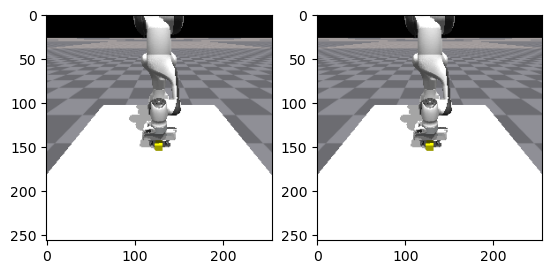

In [9]:
dataset.goal_mode = GoalMode.LAST
dataset.cache_index()

# verify length of goal sequence
for i in range(len(dataset)):
    frame = dataset[i]
    for obs_key in frame["goal"]:
        T_goal = frame["goal"][obs_key].shape[0]
        assert T_goal == 1

# verify goals across adjacent sequences are the same
for i in range(len(dataset)-1):
    if dataset.index_to_demo_id[i] == dataset.index_to_demo_id[i+1]:
        frame_a = dataset[i]
        frame_b = dataset[i+1]
        for obs_key in frame_a["goal"]:
            goal_a = frame_a["goal"][obs_key]
            goal_b = frame_b["goal"][obs_key]
            assert np.equal(goal_a, goal_b).all()

display([goal_a[0], goal_b[0]])

#### Dense Subgoals

caching index: 100%|██████████| 68/68 [00:00<00:00, 36796.89demo/s]


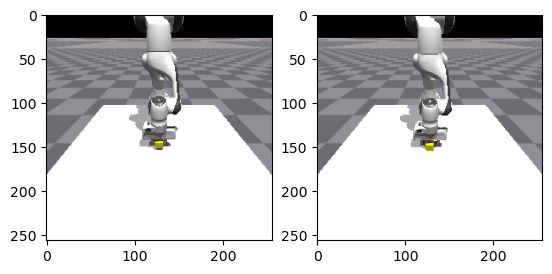

In [10]:
dataset.goal_mode = GoalMode.SUBGOAL
dataset.num_subgoal = None
dataset.cache_index()

# verify length of goal sequence
for i in range(len(dataset)):
    frame = dataset[i]
    for obs_key in frame["goal"]:
        T_goal = frame["goal"][obs_key].shape[0]
        assert T_goal == seq_length

# verify goals across adjacent sequences are shifted by single timestep
for i in range(len(dataset)-1):
    if dataset.index_to_demo_id[i] == dataset.index_to_demo_id[i+1]:
        frame_a = dataset[i]
        frame_b = dataset[i+1]
        for obs_key in frame_a["goal"]:
            goal_a = frame_a["goal"][obs_key]
            goal_b = frame_b["goal"][obs_key]
            assert np.equal(goal_a, frame_b["obs"][obs_key][frame_stack:]).all()
            assert np.equal(goal_a[1:], goal_b[:-1]).all()
            assert np.not_equal(goal_a.reshape(T_goal, -1), goal_b.reshape(T_goal, -1)).any(axis=1).all()

display([goal_a[0], goal_b[0]])

#### Sparse Subgoals

In [11]:
num_subgoal = 3

caching index: 100%|██████████| 68/68 [00:00<00:00, 10995.09demo/s]


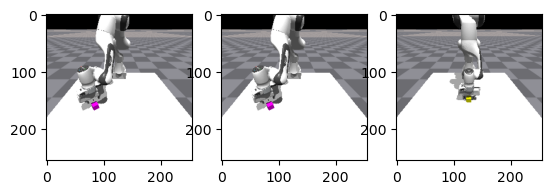

In [12]:
dataset.goal_mode = GoalMode.SUBGOAL
dataset.num_subgoal = num_subgoal
dataset.cache_index()

frame_a = dataset[0]
frame_b = dataset[1]
frame_c = dataset[-1]

# verify length of goal sequence
for obs_key in frame_a["goal"]:
    T_goal = frame_a["goal"][obs_key].shape[0]
    assert T_goal == seq_length

# verify goals differ only when subgoal changed
for obs_key in frame_a["goal"]:
    goal_a = frame_a["goal"][obs_key]
    goal_b = frame_b["goal"][obs_key]
    goal_c = frame_c["goal"][obs_key]
    assert np.equal(goal_a, goal_b).all()
    assert np.not_equal(goal_b.reshape(T_goal, -1), goal_c.reshape(T_goal, -1)).any(axis=1).all()

display([goal_a[0], goal_b[0], goal_c[0]])

#### Full Subgoals

caching index: 100%|██████████| 68/68 [00:00<00:00, 18120.25demo/s]


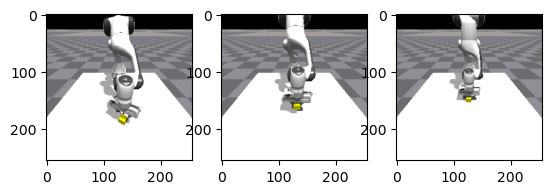

In [13]:
dataset.goal_mode = GoalMode.FULL
dataset.num_subgoal = num_subgoal
dataset.cache_index()

# verify length of goal sequence
for i in range(len(dataset)):
    frame = dataset[i]
    for obs_key in frame["goal"]:
        T_goal = frame["goal"][obs_key].shape[0]
        assert T_goal == num_subgoal

# verify goals across adjacent sequences are the same
for i in range(len(dataset)-1):
    if dataset.index_to_demo_id[i] == dataset.index_to_demo_id[i+1]:
        frame_a = dataset[i]
        frame_b = dataset[i+1]
        for obs_key in frame_a["goal"]:
            goal_a = frame_a["goal"][obs_key]
            goal_b = frame_b["goal"][obs_key]
            assert np.all(np.equal(goal_a, goal_b))

display(list(goal_a))